<a href="https://colab.research.google.com/github/sgcortes/2023_NAPLES/blob/main/BS__Ex5_2_CNN_MULTI_CLASSIFICATION_rgb_SENTINEL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
  <tr>
    <td><img src="https://unioviedo-my.sharepoint.com/:i:/g/personal/sgcortes_uniovi_es/Ebr0ybKDTBNKtoJyzmTBuRYBXY7nE-cCYaH-WDIVJxEVWA?&download=1" width="211" height="69" alt="Uniovi & EP Mieres logos" title="Uniovi & EP Mieres logos" /></td>
    <td><font color=brown>Deep Learning<br></font>
    <font color=green>Universidad de Oviedo. <br>ML & DL Naples 2023</font> <br><br>sgcortes@uniovi.es</td>
  </tr>
</table>

## Scene Multiclass Classification Example with CNN (Convolutional Neural Networks)
In this example the dataset from the file EUROSAT.zip will be clssified using a MLP. Images are RGB 64x64 pixels size. These tiles are stored in folder which names are the real class name they belong to.  

The original dataset can be dowloaded also from: http://madm.dfki.de/downloads
There are about 27.000 RGB subimages from Sentinel 2 imagery in this dataset.

In [1]:
# ESTA CELDA SOLO SE DEBE EJECUTAR UNA VEZ PARA DESCARGAR LOS DATOS. SI SE PIERDE LA CONEXIÓN DEL LIBRO PRO INACTIVIDAD SE DEBERÁ EJECUTAR DE NUEVO.
#!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
#!pip install tensorflow==2.2.0
# Las dos líneas anteriores no serán necesarias en general ya que TensorFlow está instalado por defecto en Google Colab y el enlace siguiente a uniovi shaorepoint funciona para descargar los datos. 
!wget -O EuroSAT.zip 'https://unioviedo-my.sharepoint.com/:u:/g/personal/sgcortes_uniovi_es/ESV-U5iHa_FIu2WVnU_Ysu0BLFb1BX1hzvzTFbivXLj1ZA?e=GOfJP9&download=1'
!unzip -qq EuroSAT.zip
%cd 2750

#NOTE: RUN THIS CELL ONLY ONCE. After first execution the dataset should be locally in the Google sesion content folder. Then comment the 3 commands of the cell.

--2023-05-28 19:36:22--  https://unioviedo-my.sharepoint.com/:u:/g/personal/sgcortes_uniovi_es/ESV-U5iHa_FIu2WVnU_Ysu0BLFb1BX1hzvzTFbivXLj1ZA?e=GOfJP9&download=1
Resolving unioviedo-my.sharepoint.com (unioviedo-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to unioviedo-my.sharepoint.com (unioviedo-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/sgcortes_uniovi_es/Documents/2020_VISION/EuroSAT.zip?ga=1 [following]
--2023-05-28 19:36:23--  https://unioviedo-my.sharepoint.com/personal/sgcortes_uniovi_es/Documents/2020_VISION/EuroSAT.zip?ga=1
Reusing existing connection to unioviedo-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/x-zip-compressed]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  23.3MB/s    in 4.6s    

2023-05-28 19:36:28 (19.6 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]


In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import keras


## Loading data
ruta_datos = '/content/2750/'
clases = os.listdir(ruta_datos)
print(f"List of class names:\n", clases)

List of class names:
 ['Residential', 'HerbaceousVegetation', 'Highway', 'AnnualCrop', 'Forest', 'Pasture', 'Industrial', 'SeaLake', 'PermanentCrop', 'River']


We need to store the data in arrays (tensors) with the following structure dimensions: _[#_images, #_filas #_cols, #_channels]_

In [3]:
dic_clases = {}
datos_entrada = []
datos_salida = []
i=0

for i, clase in enumerate(clases):
    if os.path.isdir(ruta_datos+clase):
        for file in os.listdir(ruta_datos+clase):
            im = Image.open(os.path.join(ruta_datos, clase, file))
            im_array = np.array(im)
            datos_entrada.append(im_array)
            datos_salida.append(i)
        dic_clases[i] = clase
        
datos_entrada = np.array(datos_entrada)
datos_salida = np.array(datos_salida)

print(f'Feature matrix dims:\n',datos_entrada.shape)
print(f'Class label vector dims:\n',datos_salida.shape) # New class label

Feature matrix dims:
 (27000, 64, 64, 3)
Class label vector dims:
 (27000,)


Display of one land cover image from of each class:

Index of the displayed image examples:
 [0, 3000, 6000, 8500, 11500, 14500, 16500, 19000, 22000, 24500]


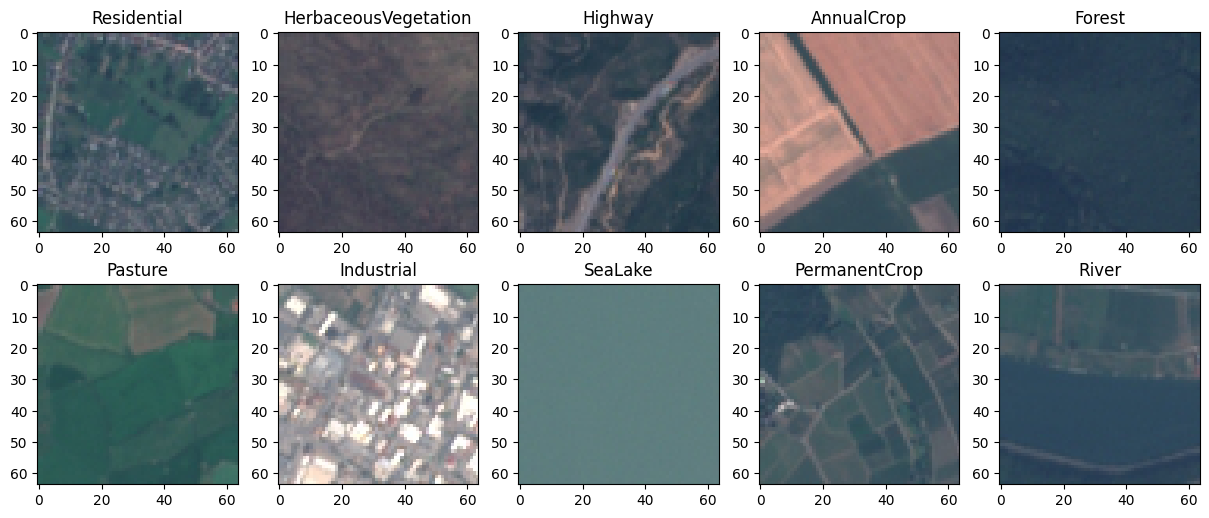

In [4]:
ind_ejemplos = [np.where(datos_salida == i)[0][0] for i in range(10)]
print('Index of the displayed image examples:\n',ind_ejemplos)
fig, axs = plt.subplots(2,5, figsize=(15,6))
axs = axs.ravel()
for i,ax in enumerate(axs):
    axs[i].imshow(datos_entrada[ind_ejemplos[i]])
    axs[i].set_title(clases[i])

In [5]:
print(f'Class labels:\n',np.unique(datos_salida))

Class labels:
 [0 1 2 3 4 5 6 7 8 9]


### Splitting data for training and testing and one hot encoding for class labels

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, clases_train, clases_test = train_test_split(datos_entrada,
                                                           datos_salida,
                                                           train_size=0.8,
                                                           random_state=1,
                                                           shuffle=True)

# convertir la salida a foramto "one-hot"
y_train = keras.utils.to_categorical(clases_train)
y_test = keras.utils.to_categorical(clases_test)

### Normalizing Digital Numbers from images

In [7]:
# Imáge normalization
x_train = x_train/255
x_test =x_test/255

In [8]:
# Checking data sizes:
print(f'Feature matrix Training set dims:\n',x_train.shape)
print(f'Feature matrix Test set dims:\n',x_test.shape)

print(f'Class label vector Training set dims:\n',y_train.shape)
print(f'Class label vector Test set dims:\n',y_test.shape)

Feature matrix Training set dims:
 (21600, 64, 64, 3)
Feature matrix Test set dims:
 (5400, 64, 64, 3)
Class label vector Training set dims:
 (21600, 10)
Class label vector Test set dims:
 (5400, 10)


### Model 1: CNN, Convolutional Neural Network
A efectos de comparación de las métricas de desempeño podemos emplear como punto de comparación un modelo CNN

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D
from keras.layers import MaxPooling2D, Flatten


cnn = Sequential()
cnn.add(Conv2D(64, 5, strides = (2,2),
              activation='relu',
              padding = 'same',
              input_shape = (64,64,3)))

cnn.add(Conv2D(64, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))

cnn.add(Conv2D(64, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))

cnn.add(Flatten())       
cnn.add(Dense(50, activation = 'relu'))
cnn.add(Dense(10, activation = 'softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 50)                204850    
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 284,080
Trainable params: 284,080
Non-trai

In [10]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [11]:
hist = cnn.fit(x_train, y_train,
               epochs =25,
               batch_size =32,
               validation_data=(x_test, y_test))

Epoch 1/25
675/675 [==============================] - 17s 8ms/step - loss: 1.6862 - accuracy: 0.3469 - val_loss: 1.4369 - val_accuracy: 0.4724
Epoch 2/25
675/675 [==============================] - 4s 5ms/step - loss: 1.2242 - accuracy: 0.5548 - val_loss: 1.0733 - val_accuracy: 0.6143
Epoch 3/25
675/675 [==============================] - 4s 5ms/step - loss: 0.9410 - accuracy: 0.6650 - val_loss: 0.8417 - val_accuracy: 0.7065
Epoch 4/25
675/675 [==============================] - 4s 7ms/step - loss: 0.7870 - accuracy: 0.7165 - val_loss: 0.7313 - val_accuracy: 0.7426
Epoch 5/25
675/675 [==============================] - 4s 5ms/step - loss: 0.6680 - accuracy: 0.7602 - val_loss: 0.8085 - val_accuracy: 0.7067
Epoch 6/25
675/675 [==============================] - 4s 5ms/step - loss: 0.6163 - accuracy: 0.7810 - val_loss: 0.7129 - val_accuracy: 0.7435
Epoch 7/25
675/675 [==============================] - 4s 6ms/step - loss: 0.5441 - accuracy: 0.8077 - val_loss: 0.8574 - val_accuracy: 0.7109
Epoch

### Accuracy and cost function graphics

In [12]:
def plot_AccAndLoss(hist):
  fig1 = plt.figure()
  plt.plot(hist.history['accuracy'],label='Accuracy')
  plt.grid()
  plt.title('Accuracy & Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy & Loss')
  plt.plot(hist.history['loss'],label='Loss function');
  plt.legend()

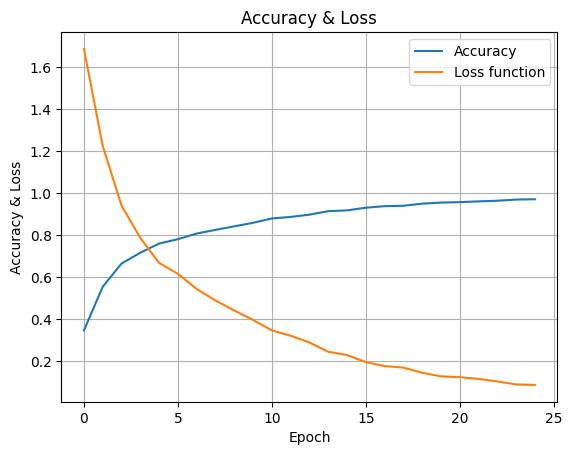

In [13]:
plot_AccAndLoss(hist)

## MaxPooling
Adding Max pooling can allow us to increase the number of "filters" in each layer 

In [14]:
cnn2 = Sequential()
cnn2.add(Conv2D(128, 5, strides = (2,2),
              activation='relu',
              padding = 'same',
              input_shape = (64,64,3)))
cnn2.add(MaxPooling2D(pool_size=2))

cnn2.add(Conv2D(128, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))
cnn2.add(MaxPooling2D(pool_size=2))

cnn2.add(Conv2D(128, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))
cnn2.add(MaxPooling2D(pool_size=2))

cnn2.add(Flatten())       
cnn2.add(Dense(50, activation = 'relu'))
cnn2.add(Dense(10, activation = 'softmax'))
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)       

In [15]:
cnn2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [16]:
hist = cnn2.fit(x_train, y_train,
               epochs =25,
               batch_size =32,
               validation_data=(x_test, y_test))

Epoch 1/25
675/675 [==============================] - 7s 7ms/step - loss: 1.4438 - accuracy: 0.4425 - val_loss: 1.1043 - val_accuracy: 0.5967
Epoch 2/25
675/675 [==============================] - 4s 6ms/step - loss: 1.0203 - accuracy: 0.6231 - val_loss: 0.9410 - val_accuracy: 0.6489
Epoch 3/25
675/675 [==============================] - 4s 6ms/step - loss: 0.9057 - accuracy: 0.6674 - val_loss: 0.8164 - val_accuracy: 0.7037
Epoch 4/25
675/675 [==============================] - 4s 6ms/step - loss: 0.7569 - accuracy: 0.7245 - val_loss: 1.1046 - val_accuracy: 0.6198
Epoch 5/25
675/675 [==============================] - 4s 6ms/step - loss: 0.6676 - accuracy: 0.7609 - val_loss: 0.5949 - val_accuracy: 0.7802
Epoch 6/25
675/675 [==============================] - 4s 6ms/step - loss: 0.6147 - accuracy: 0.7771 - val_loss: 0.5728 - val_accuracy: 0.7981
Epoch 7/25
675/675 [==============================] - 4s 6ms/step - loss: 0.5618 - accuracy: 0.8006 - val_loss: 0.5602 - val_accuracy: 0.8074
Epoch 

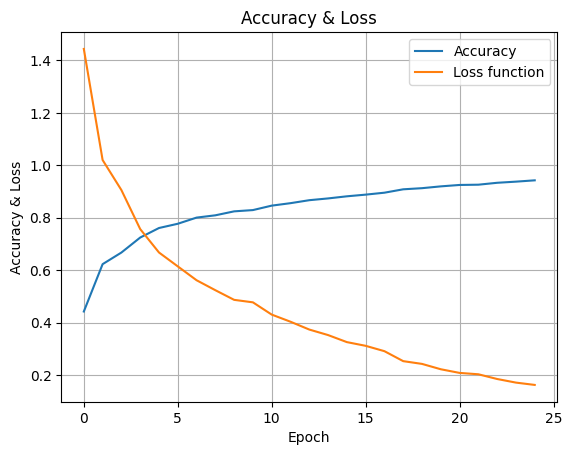

In [17]:
plot_AccAndLoss(hist)

### A deeper network
Let's make a deeper network

In [18]:
cnn3 = Sequential()
cnn3.add(Conv2D(16, 5,activation='relu',padding = 'same',input_shape = (64,64,3)))
cnn3.add(Conv2D(16, 5, strides = (2,2),activation='relu',padding = 'same',input_shape = (64,64,3)))
cnn3.add(MaxPooling2D(pool_size=2))

cnn3.add(Conv2D(256, 3,activation='relu',padding = 'same'))
cnn3.add(Conv2D(256, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))
cnn3.add(MaxPooling2D(pool_size=2))

cnn3.add(Conv2D(512, 3,activation='relu',padding = 'same'))
cnn3.add(Conv2D(512, 3,activation='relu',padding = 'same'))
cnn3.add(MaxPooling2D(pool_size=2))

cnn3.add(Conv2D(1024, 3,activation='relu',padding = 'same'))
cnn3.add(Conv2D(1024, 3,activation='relu',padding = 'same'))
cnn3.add(MaxPooling2D(pool_size=2))

cnn3.add(Flatten()) 
cnn3.add(Dropout(0.4))
cnn3.add(Dense(50, activation = 'relu'))
cnn3.add(Dense(10, activation = 'softmax'))
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        1216      
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        6416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)       37120     
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 256)        0         
 2D)                                                  

In [19]:
cnn3.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [20]:
hist = cnn3.fit(x_train, y_train,
               epochs =15,
               batch_size =32,
               validation_data=(x_test, y_test))

Epoch 1/15
675/675 [==============================] - 28s 33ms/step - loss: 1.6326 - accuracy: 0.3241 - val_loss: 1.6203 - val_accuracy: 0.3406
Epoch 2/15
675/675 [==============================] - 20s 30ms/step - loss: 1.1790 - accuracy: 0.5503 - val_loss: 0.8911 - val_accuracy: 0.6902
Epoch 3/15
675/675 [==============================] - 20s 30ms/step - loss: 0.8926 - accuracy: 0.6813 - val_loss: 0.7564 - val_accuracy: 0.7206
Epoch 4/15
675/675 [==============================] - 22s 32ms/step - loss: 0.7923 - accuracy: 0.7146 - val_loss: 0.7805 - val_accuracy: 0.7159
Epoch 5/15
675/675 [==============================] - 21s 30ms/step - loss: 0.7215 - accuracy: 0.7448 - val_loss: 0.7674 - val_accuracy: 0.7263
Epoch 6/15
675/675 [==============================] - 21s 31ms/step - loss: 0.6631 - accuracy: 0.7649 - val_loss: 0.7018 - val_accuracy: 0.7633
Epoch 7/15
675/675 [==============================] - 21s 31ms/step - loss: 0.6128 - accuracy: 0.7848 - val_loss: 0.6117 - val_accuracy:

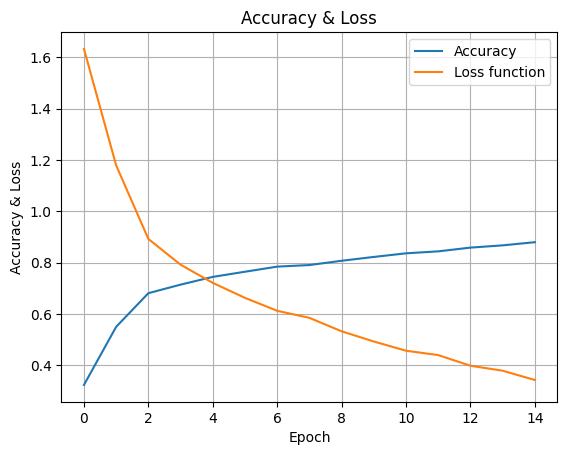

In [21]:
plot_AccAndLoss(hist)

## Batch Normalization

In [22]:
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D
from keras.layers import MaxPooling2D, Flatten

cnn4 = Sequential()
cnn4.add(Conv2D(16, 5,activation='relu',padding = 'same',input_shape = (64,64,3)))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(16, 5,activation='relu',padding = 'same',input_shape = (64,64,3)))
cnn4.add(MaxPooling2D(pool_size=2))

cnn4.add(Conv2D(32, 3,activation='relu',padding = 'same'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(32, 3,activation='relu',padding = 'same'))
cnn4.add(MaxPooling2D(pool_size=2))

cnn4.add(Conv2D(64, 3,activation='relu',padding = 'same'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(64, 3,activation='relu',padding = 'same'))
cnn4.add(MaxPooling2D(pool_size=2))

cnn4.add(Conv2D(128, 3,activation='relu',padding = 'same'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128, 3,activation='relu',padding = 'same'))
cnn4.add(MaxPooling2D(pool_size=2))

cnn4.add(Flatten()) 
cnn4.add(Dropout(0.4))
cnn4.add(Dense(50, activation = 'relu'))
cnn4.add(Dense(10, activation = 'softmax'))
cnn4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 64, 64, 16)        1216      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 16)        6416      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)      

In [23]:
cnn4.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [24]:
hist4 = cnn4.fit(x_train, y_train,
               epochs =25,
               batch_size =32,
               validation_data=(x_test, y_test))

Epoch 1/25
675/675 [==============================] - 15s 12ms/step - loss: 1.1543 - accuracy: 0.5902 - val_loss: 1.6136 - val_accuracy: 0.4685
Epoch 2/25
675/675 [==============================] - 7s 11ms/step - loss: 0.7135 - accuracy: 0.7501 - val_loss: 0.8656 - val_accuracy: 0.7022
Epoch 3/25
675/675 [==============================] - 7s 11ms/step - loss: 0.5038 - accuracy: 0.8275 - val_loss: 0.7116 - val_accuracy: 0.7531
Epoch 4/25
675/675 [==============================] - 8s 11ms/step - loss: 0.4113 - accuracy: 0.8617 - val_loss: 0.5366 - val_accuracy: 0.8304
Epoch 5/25
675/675 [==============================] - 7s 11ms/step - loss: 0.3557 - accuracy: 0.8784 - val_loss: 1.1330 - val_accuracy: 0.6359
Epoch 6/25
675/675 [==============================] - 8s 11ms/step - loss: 0.3109 - accuracy: 0.8957 - val_loss: 0.4186 - val_accuracy: 0.8630
Epoch 7/25
675/675 [==============================] - 7s 11ms/step - loss: 0.2723 - accuracy: 0.9084 - val_loss: 1.0382 - val_accuracy: 0.699

## Training and Validation precisions. (Inner and external precisions)

In [25]:
acc_train = cnn4.evaluate(x_train, y_train)[1]*100
acc_test = cnn4.evaluate(x_test, y_test)[1]*100

print('Training accuracy: ', format(acc_train, '.2f'), '%')
print('Test accuracy: ', format(acc_test, '.2f'), '%')

169/169 [==============================] - 1s 5ms/step - loss: 0.2698 - accuracy: 0.9272
Training accuracy:  97.64 %
Test accuracy:  92.72 %


## Model Validation
Let´s see the confusion matrix for test and training sets.

In [1]:
y_prob_train = cnn4.predict(x_train)
y_prob_test = cnn4.predict(x_test)

y_pred_train = np.argmax(y_prob_train, axis=1)
y_pred_test = np.argmax(y_prob_test, axis=1)
print(y_pred_train[0:5])

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix

cm = confusion_matrix(clases_test,y_pred_test)

# confusion matrix Graphics

clases = np.unique(clases_test)
fig,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

# Add title and lables to the confusion matrix graphic
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=clases, yticklabels=clases,
       title='Confusion Matrix',
       ylabel='Predicted Clases',
       xlabel='True Classes')

# Rota los nombres de las etiquetas en el eje x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j,i, cm[i,j],
               ha="center", va="center",
               color="white" if cm[i,j] <350 else "black")
plt.show()

## Metrics: precision, recall, accuracy and F1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score

acc_train = accuracy_score(clases_train, y_pred_train)
acc_test = accuracy_score(clases_test, y_pred_test)

prec_train = precision_score(clases_train, y_pred_train, average='macro')
prec_test = precision_score(clases_test, y_pred_test, average='macro')

rec_train = recall_score(clases_train, y_pred_train, average='macro')
rec_test = recall_score(clases_test, y_pred_test, average='macro')

f1_train = f1_score(clases_train, y_pred_train, average='macro')
f1_test = f1_score(clases_test, y_pred_test, average='macro')

print('Training Accuracy: ', format(100*acc_train, '.2f'),'%')
print('Validation Accuracy: ', format(100*acc_test, '.2f'),'\n')


print('Training Precision: ', format(100*prec_train, '.2f'),'%')
print('Validation Precision: ', format(100*prec_test, '.2f'),'\n')

print('Training Recall: ', format(100*rec_train, '.2f'),'%')
print('Validation Recall: ', format(100*rec_test, '.2f'),'\n')

print('Training F1: ', format(f1_train, '.3f'))
print('Validation F1: ', format(f1_test, '.3f'),'\n')

## Displaying some predictions

In [ ]:
from keras.layers.convolutional.conv3d import Convolution3D
y_proba = cnn4.predict(x_test)
num = [150,300,4, 1300]
print("Probability values:\n",y_proba[num])

# The highest probability value would be:
highp = np.argmax(y_proba[num])

fig, axs = plt.subplots(2,5, figsize=(15,6))
axs = axs.ravel()
for i in enumerate(num):
    plt.imshow(x_test[num[i]].reshape(64,64,3))
    plt.set_title(dic_clases[i])
    

